In [65]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [66]:
#filepath: C:\Users\olubl\OneDrive\College\Data+\DPS-Planning\GIS_files\hs_full_geo.geojson
filepath = input('Please input the filepath to student counts shapefile: ')
hs_full_geo = gpd.read_file(filepath).to_crs(epsg=3857)

Please input the filepath to student counts shapefile:  C:\Users\olubl\OneDrive\College\Data+\DPS-Planning\GIS_files\hs_full_geo.geojson


In [67]:
#filepath2: C:\Users\olubl\OneDrive\College\Data+\DPS-Planning\dps_base_2324.geojson
filepath2 = input('Please input the filepath to the DPS schools shapefile: ')
dps_base = gpd.read_file(filepath2).to_crs(epsg = 3857)

Please input the filepath to the DPS schools shapefile:  C:\Users\olubl\OneDrive\College\Data+\DPS-Planning\dps_base_2324.geojson


In [68]:
school_list = input('\nPlease enter the schools you wish to include (comma seperated): ')
selected_schools = [s.strip() for s in school_list.split(',')]
filtered_schools = dps_base[dps_base['name'].isin(selected_schools)][['name','geometry']]

schools_model = filtered_schools.set_index('name').loc[selected_schools].reset_index()


Please enter the schools you wish to include (comma seperated):  Southern High School, Durham School of the Arts, Riverside High School, Hillside High School, Jordan High School


In [69]:
school_count = len(schools_model)
schools_model.loc[school_count,'name']='New High School'
schools_model

,name,geometry
0,Southern High School,POINT (-8.78e+06 4.3e+06)
1,Durham School of the Arts,POINT (-8.78e+06 4.3e+06)
2,Riverside High School,POINT (-8.79e+06 4.31e+06)
3,Hillside High School,POINT (-8.78e+06 4.29e+06)
4,Jordan High School,POINT (-8.79e+06 4.29e+06)
5,New High School,None


In [70]:
#precomputed stuff for function
#capacities_orig = [1240,1540,1600,1240,1510,1600]
school_names = schools_model['name'].tolist()
capacities_input = input('Please enter the capacities of the schools in order, ending with the new school: ')
capacities = [int(s) for s in capacities_input.split(',')]

Please enter the capacities of the schools in order, ending with the new school:  1340,1335,1400,1240,1510,1550


In [71]:
#local copies of dfs
local_hs_full_geo = hs_full_geo.copy()
local_dps_base_hs = schools_model.copy()

In [72]:
def score_candidate(candidate,sgr,lower_bound,upper_bound):
    i=0
    counts = pd.DataFrame({'school':school_names,
                           'capacity':capacities,
                           'count':[0,0,0,0,0,0],
                           'adjust':[0,0,0,0,0,0]
                            })                              

    
    candidate_geom = candidate['geometry']
    local_dps_base_hs.loc[school_count,'geometry']=candidate_geom.centroid
    counts['pct_capacity'] = counts['count']/counts['capacity']
    
    
    while ((counts['pct_capacity']<lower_bound/100)|(counts['pct_capacity']>upper_bound/100)).any() and i<=200:                                    
        assignments = []
        for pu in local_hs_full_geo.itertuples(index=False):                   
            centroid = pu.geometry.centroid
            pu_scores = []
            for j in range(school_count+1):    
                dist = centroid.distance(local_dps_base_hs.loc[j,'geometry'])
                score = dist + counts.loc[j,'adjust']
                pu_scores.append(score)
            assign = school_names[pu_scores.index(min(pu_scores))]
            assignments.append(assign)
        local_hs_full_geo['assign'] = assignments
    
        for j,school in enumerate(school_names):
            assigned_students = int(local_hs_full_geo.loc[local_hs_full_geo['assign'] == school, 'basez'].sum() + local_hs_full_geo.loc[local_hs_full_geo['assign'] == school, 'student_gen'].sum()*sgr/100)
            counts.loc[j, 'count'] = assigned_students  
                
            if counts.loc[j,'count'] <= counts.loc[j,'capacity']*lower_bound/100:
                counts.loc[j,'adjust'] -= 200
            elif counts.loc[j,'count'] >= counts.loc[j,'capacity']*upper_bound/100:
                counts.loc[j,'adjust'] += 200
            else:
                pass
        counts['pct_capacity'] = counts['count']/counts['capacity']
        i+=1

    if i<=200:
        objective=local_hs_full_geo.merge(local_dps_base_hs,left_on='assign',right_on='name',how='left')
        objective['distance']=objective['geometry_x'].distance(objective['geometry_y'])
        objective_score = ((objective['basez']+sgr*objective['student_gen']/100)*objective['distance']).sum()/(10**7)
        return objective_score,i,counts.drop(columns=['adjust'])

    else:
        return 'Failed to set boundaries within 200 tries. Try again with different capacity bounds.',counts


In [73]:
pu = int(input('What planning unit to site? '))
sgr = int(input('What percent of SGR would you like to include? '))
low = int(input('What lower bound of capacity? '))
up = int(input('What upper bound of capacity? '))

What planning unit to site?  316
What percent of SGR would you like to include?  15
What lower bound of capacity?  70
What upper bound of capacity?  100


In [74]:
candidate = local_hs_full_geo.loc[pu]
score_candidate(candidate,sgr,low,up)

(2.9923748579010234,
 10,
                       school  capacity  count  pct_capacity
 0       Southern High School      1340   1319      0.984328
 1  Durham School of the Arts      1335   1290      0.966292
 2      Riverside High School      1400   1396      0.997143
 3       Hillside High School      1240   1080      0.870968
 4         Jordan High School      1510   1409      0.933113
 5            New High School      1550   1402      0.904516)

<Axes: title={'center': 'Expanded HS Boundaries'}>

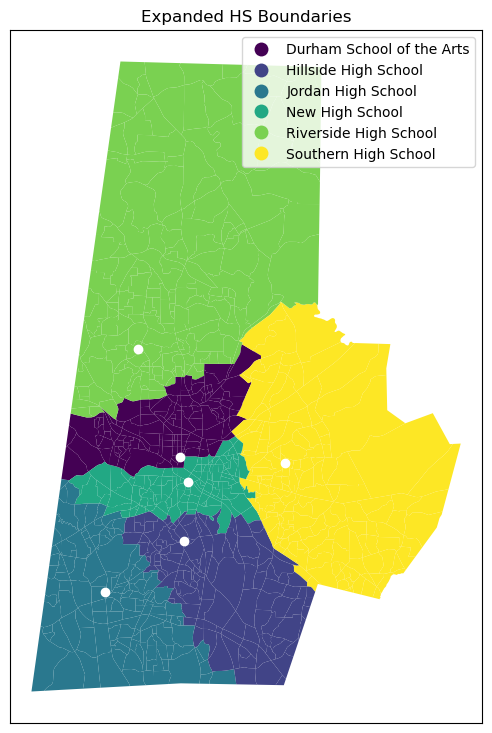

In [75]:
fig,ax = plt.subplots(figsize = (7,9))

local_hs_full_geo.plot(
    column='assign',
    ax = ax,
    cmap = 'viridis',
    legend = True
)

ax.set_xticks([])
ax.set_yticks([])

plt.title('Expanded HS Boundaries')
local_dps_base_hs.plot(ax=plt.gca(), color = 'white')